# Examining Behavior of SPX Options on Expiration Day

### 1) Data Cleaning and Preparation
- Consolidate intraday minutely data from daily SPX yahoo pulls
- Consolidate VIX intraday prices from daily VIX options files
- Consolidate 0 DTE expiration options from daily SPX options pulls
- Retrieve live minutely data from Alphavantage

### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min, 10 min, 15 min, 20 min, 30 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

### 3) Relationship of VIX Intraday to 0 DTE Option IV
- Check if VIX and IV use calendar or trading days to annualize
    - **IV on the options chain is in calendar years with 24 hour days -> minutes_remaining/(60 x 24 x 365.25)**
- Determine Function of Skew using 3rd and 4th moments
- Plot IV surface against strikes and time of day
- Check behavior of IV movement given VIX term structure is in Contango or Backwardation

### 4) Expiration Day Option Pricing
- Implied Binomial Pricing model using probability inferred from option prices
- Monte Carlo using implied binomial probabilities then backing out he IV from simulated option prices
- Use Black Scholes but IV based on VIX intraday or HV from intraday SPX
- **Track the IV live on the option chain in IB and use BS to calculate the delta to confirm validity**


### 5) 1 DTE Overnight Options Short Vol
- Test buckets of VIX brackets and put spreads from 1 hour, 2 hour, or 3 hours before market close and premium the next day
- Test overnight volatility vs intraday volatility of SPX during high IV and low IV
- Test intraday VIX correlation with SPX and trends
- Use ARIMA for trend significance throughout the day
- Use ADF for mean reversion significance throughout the day
- Infer (r - q) from ES and SPX spot prices and see whether they conform to options prices of SPX and ES

##### Importing Necessary Modules

In [705]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas.stats.moments as st
import statsmodels.tsa.stattools as ts
from pandas_datareader.data import Options
pd.options.display.float_format = '{:,.4f}'.format

import numpy as np
import datetime as dt
import time

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

from sqlalchemy import *
from sqlalchemy import create_engine
import sqlite3 as sql
from scipy.stats import norm as norm

import py_vollib.black.greeks.analytical as py_greeks
import py_vollib.ref_python.black_scholes as py_bs
import os
main_dir = os.getcwd()
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\RetiredModules')
from helpers import maturities
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')
cleaned_dir = 'D:\\Options Data\\Monthly DBs'
from yahoo_query import *

def alpha_vantage(ticker, key):
    if key == 0:
        api_key = '5HZEUI5AFJB06BUK'
    else:
        api_key = '6ZAZOL7YF8VPXND7'
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={0}&interval=1min&outputsize=full&apikey={1}&datatype=csv' 
    df = pd.read_csv(url.format(ticker, api_key), index_col = 0).sort_index()
    df.index = pd.to_datetime(df.index)    
    return df

from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.graphics.tsaplots import plot_acf

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, len(ts) - 1)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def hurst_ernie_chan(p):

    variancetau = []; tau = []
    lags = range(2, len(p) - 1)
    
    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

##### 1) Data Preparation

In [125]:
# Retrieving Data for VIX Term Structure
v1 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
v2 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', skiprows=[0], index_col = 0)
vix.index = pd.to_datetime(vix.index)
vix_term = vix.join(v1.join(v2, lsuffix = '_F1', rsuffix = '_F2').dropna()).dropna()
vix_term['Front_Weights'] = np.nan
vix_term['Back_Weights'] = np.nan

for index, row in vix_term.iterrows():
    weights = maturities(index.date())
    front_weight = weights[0]
    back_weight = weights[1]
    vix_term.loc[index, 'Front_Weights'] = front_weight
    vix_term.loc[index, 'Back_Weights'] = back_weight
    
vix_term = vix_term[list(filter(lambda x: 'Open' in x or 'Weight' in x, vix_term.columns.tolist()))]
vix_term['Contango_Ratio'] = vix_term.Front_Weights*(vix_term['VIX Open']/vix_term.Open_F1) + vix_term.Back_Weights*(vix_term.Open_F1/vix_term.Open_F2)
vix_term = vix_term[vix_term.index >= dt.datetime(2018,7,30)]

# Retrieving Data For Intraday SPX and VIX Indices from Local Databases
os.chdir(cleaned_dir)
vix_intraday = pd.read_csv('vix_intraday.csv', index_col = 0).set_index('Quote_Time')
vix_intraday.index = pd.to_datetime(vix_intraday.index)
vix_intraday = vix_intraday[~vix_intraday.index.duplicated(keep='last')].sort_index()

spx_intraday = []
calls_intraday = []
puts_intraday = []

for curr_date in [dt.datetime(2018,x,1) for x in range(7,13)] + [dt.datetime(2019,1,1)]:
    db_name = 'sqlite:///intraday_{0}-{1}.db'.format(curr_date.year,curr_date.month)
    options_engine = create_engine(db_name, echo=False)
    latest_spx = pd.read_sql_query('SELECT * FROM spx_prices', con = options_engine, index_col = 'index')
    latest_spx.index = pd.to_datetime(latest_spx.index)
    spx_intraday.append(latest_spx)
    
    options_query = 'SELECT * FROM spx_{} WHERE DTE = 0'
    
    latest_calls = pd.read_sql_query(options_query.format('calls'), con = options_engine, index_col = 'quoteTime')
    latest_calls.index = pd.to_datetime(latest_calls.index)
    calls_intraday.append(latest_calls)
    
    latest_puts = pd.read_sql_query(options_query.format('puts'), con = options_engine, index_col = 'quoteTime')
    latest_puts.index = pd.to_datetime(latest_puts.index)
    puts_intraday.append(latest_puts)
    
spx_intraday = pd.concat(spx_intraday, axis = 0)
spx_intraday['Date'] = spx_intraday.index.date
calls_intraday = pd.concat(calls_intraday, axis = 0)
puts_intraday = pd.concat(puts_intraday, axis = 0)

# Cleaning SPX Intraday Data
exclusions = spx_intraday.groupby('Date').count()
exclusions = exclusions.reset_index()

exclusion_dates = exclusions[(exclusions['Last'] <= 350) | (exclusions.Last > 391)].Date.tolist()
spx_intraday = spx_intraday[spx_intraday.Date.isin(exclusion_dates) == False]

impute_dates = exclusions[(exclusions.Last != 391) & (exclusions.Date.isin(exclusion_dates) == False)]

model_day = spx_intraday[spx_intraday.Date == dt.date(2018,7,31)].copy()

corrected_df_list = []

for date_to_correct in impute_dates.Date:
    df_to_correct = spx_intraday[spx_intraday.Date == date_to_correct].copy()
    time_delta_adj = df_to_correct.Date.head(1).values[0] - model_day.Date.head(1).values[0]
    
    df_to_join = model_day.copy()
    df_to_join.index = df_to_join.index + time_delta_adj
    del df_to_join['Last'], df_to_join['Date']
    
    df_to_correct = df_to_join.join(df_to_correct)
    df_to_correct.Date = df_to_correct.index.date
    df_to_correct = df_to_correct.fillna(method = 'bfill')
    
    corrected_df_list.append(df_to_correct)
    
corrected_spx_df = pd.concat(corrected_df_list, axis = 0)
spx_intraday = pd.concat([spx_intraday[spx_intraday.Date.isin(impute_dates.Date.tolist()) == False],
                          corrected_spx_df], axis = 0).sort_index()

further_exclusion_dates = [dt.date(2018,10,10), dt.date(2018,9,3), dt.date(2018,12,24),
                           dt.date(2018,12,25), dt.date(2019,1,1)]

spx_intraday = spx_intraday[spx_intraday.Date.isin(further_exclusion_dates) == False]

tol = pd.Timedelta('180 second')
index_intraday = pd.merge_asof(left=spx_intraday,right=vix_intraday[['Underlying_Price']],
                               right_index=True,
                               left_index=True,
                               direction='nearest',
                               tolerance=tol).dropna()
index_intraday.columns = ['SPX','Date','VIX']

##### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

**ADF test for random walk** <br>
- The test statistic is a negative number and thus in order to be significant beyond the critical values, the number must be more negative than these values, i.e. less than the critical values.
- The ADF null hypothesis is that the process is a random walk and thus non mean-reverting (i.e., a high p-value indicates that we fail to reject the null that it is a random walk)
- The output of the Augmented Dickey-Fuller test over a period is as follows:
    - The first value is the calculated test-statistic
    - The second value is the p-value.
    - The fourth is the number of data points in the sample. 
    - The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

**Hurst Exponent Test for Stationarity** <br>
A time series can then be characterised in the following manner:
- H < 0.5 - The time series is mean reverting
- H = 0.5 - The time series is a Geometric Brownian Motion
- H > 0.5 - The time series is trending

**Autocorrelation is highest most often during the times of 9:30 AM to 10:00 AM and 1:00 PM to 2:00 PM** <br>
**Non-mean reverting series occurs most often at 9:30 AM to 10:00 AM and from 1:00 PM to 3:00 PM**

In [431]:
def intraday_autocorr(price_series, curr_date):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    
    return [price_series.Last.pct_change().dropna().autocorr()] + [block.Last.pct_change().dropna().autocorr() for block in block_series]

def intraday_ts_tests(price_series, curr_date, use_5min = False):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    if use_5min:
        block_series[0] = price_series[(price_series.index <= dt.datetime(curr_date.year,
                                                                          curr_date.month, 
                                                                          curr_date.day, 10, 30))]

    return [(ts.adfuller(price_series.Last)[1], 
             hurst_ernie_chan(price_series.Last))] + [(ts.adfuller(block.Last)[1], 
                                            hurst_ernie_chan(block.Last)) for block in block_series]

def create_stats_df(interval_dict):
    for i, k in enumerate(interval_dict.keys()):
        if i == 0:
            curr_interval_df = pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates())
        else:
            curr_interval_df = curr_interval_df.join(pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates()),
                                                     rsuffix = '_{}'.format(k))

    return curr_interval_df

intervals_1min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
                  'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
                  'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
                  'timeblock6': {'hurst':[],'adf':[]}}
intervals_5min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
                  'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
                  'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
                  'timeblock6': {'hurst':[],'adf':[]}}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    
    
    curr_1min_tests = intraday_ts_tests(curr_day_spx, curr_date)
    curr_5min_tests = intraday_ts_tests(curr_5min, curr_date, True)
    
    i = 0
    for k,v in intervals_1min.items():
        intervals_1min[k]['hurst'].append(curr_1min_tests[i][1])
        intervals_1min[k]['adf'].append(curr_1min_tests[i][0])

        i += 1
        
    i = 0
    for k,v in intervals_5min.items():
        intervals_5min[k]['hurst'].append(curr_5min_tests[i][1])
        intervals_5min[k]['adf'].append(curr_5min_tests[i][0])

        i += 1
        
intervals_1min = create_stats_df(intervals_1min)
intervals_5min = create_stats_df(intervals_5min)

In [382]:
adfs_1min = intervals_1min[list(filter(lambda x: 'adf' in x, intervals_1min.columns.tolist()))]
adfs_5min = intervals_5min[list(filter(lambda x: 'adf' in x, intervals_5min.columns.tolist()))]

hurst_1min = intervals_1min[list(filter(lambda x: 'hurst' in x, intervals_1min.columns.tolist()))]
hurst_5min = intervals_5min[list(filter(lambda x: 'hurst' in x, intervals_5min.columns.tolist()))]

idx = ['full_day', 'timeblock1', 'timeblock2', 'timeblock3','timeblock4', 'timeblock5', 'timeblock6']

adf_summary = {'adf_1min':[],
                 'adf_5min':[]}

for col in adfs_1min.columns:
    adf_summary['adf_1min'].append(len(adfs_1min[adfs_1min[col] < 0.05]))
    adf_summary['adf_5min'].append(len(adfs_5min[adfs_5min[col] < 0.05]))

In [391]:
day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
time_blocks = [str([x.strftime('%H:%M') for x in block]).replace('[','').replace(']','').replace("'",'') for block in day_blocks]

hurst_1min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

hurst_5min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

for col in hurst_1min.columns:
    hurst_1min_summary['mr_counts'].append(len(hurst_1min[hurst_1min[col] < 0.4]))
    hurst_1min_summary['trend_counts'].append(len(hurst_1min[hurst_1min[col] > 0.6]))
    hurst_1min_summary['gbm_counts'].append(len(hurst_1min[(hurst_1min[col] <= 0.6) & (hurst_1min[col] >= 0.4)]))
    
for col in hurst_5min.columns:
    hurst_5min_summary['mr_counts'].append(len(hurst_5min[hurst_5min[col] < 0.4]))
    hurst_5min_summary['trend_counts'].append(len(hurst_5min[hurst_5min[col] > 0.6]))
    hurst_5min_summary['gbm_counts'].append(len(hurst_5min[(hurst_5min[col] <= 0.6) & (hurst_5min[col] >= 0.4)]))

pd.DataFrame(adf_summary,index = idx).join(pd.DataFrame(hurst_1min_summary,index = idx),
                                           rsuffix = '_hurst1').join(pd.DataFrame(hurst_5min_summary,index = idx),
                                                                     rsuffix = '_hurst5')

,adf_1min,adf_5min,gbm_counts,mr_counts,trend_counts,gbm_counts_hurst5,mr_counts_hurst5,trend_counts_hurst5
full_day,12,12,0,108,0,0,108,0
timeblock1,17,9,0,107,0,1,107,0
timeblock2,7,3,0,107,0,0,107,0
timeblock3,8,6,0,107,0,0,108,0
timeblock4,12,3,0,108,0,0,108,0
timeblock5,12,13,0,108,0,0,108,0
timeblock6,5,7,0,107,0,0,107,0


In [432]:
autocorr_idx = idx + ['timeblock7']

intervals_1min_autocorr = {k:[] for k in autocorr_idx}
intervals_5min_autocorr = {k:[] for k in autocorr_idx}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    

    autocorrs_1min = intraday_autocorr(curr_day_spx, curr_date)
    autocorrs_5min = intraday_autocorr(curr_5min, curr_date)
    
    for i,v in enumerate(autocorrs_1min):
        intervals_1min_autocorr[autocorr_idx[i]].append(v)
    
    for i,v in enumerate(autocorrs_5min):
        intervals_5min_autocorr[autocorr_idx[i]].append(v)

intervals_1min_autocorr = pd.DataFrame(intervals_1min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())
intervals_5min_autocorr = pd.DataFrame(intervals_5min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())

In [450]:
autocorr_1min_summary = {k:[] for k in intervals_1min_autocorr.columns}
autocorr_5min_summary = {k:[] for k in intervals_5min_autocorr.columns}

for col in intervals_1min_autocorr.columns:
    autocorr_1min_summary[col].append(len(intervals_1min_autocorr[abs(intervals_1min_autocorr[col]) > 0.3]))
    autocorr_5min_summary[col].append(len(intervals_5min_autocorr[abs(intervals_5min_autocorr[col]) > 0.3]))

In [451]:
pd.DataFrame(autocorr_1min_summary, 
             index = ['interval_1min']).T.join(pd.DataFrame(autocorr_5min_summary,
                                                            index = ['interval_5min']).T)

,interval_1min,interval_5min
full_day,0,0
timeblock1,11,67
timeblock2,3,28
timeblock3,2,40
timeblock4,2,25
timeblock5,2,27
timeblock6,3,30
timeblock7,4,37


In [844]:
token = 0

spx = alpha_vantage('SPX',token)
vix = alpha_vantage('VIX',token)

In [845]:
for i in range(20, len(spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)]), 20):
    print('Lookback {} Periods:'.format(i))
    print('ADF:')
    print(ts.adfuller(spx.close.tail(i)))
    print('Hurst:')
    print(hurst_ernie_chan(spx.close.tail(i)))
    print('Autocorr:')
    print(spx.close.tail(i).pct_change().autocorr())
    print('')

Lookback 20 Periods:
ADF:
(-0.0, 0.95853208606005602, 9, 10, {'1%': -4.3315729999999997, '5%': -3.2329500000000002, '10%': -2.7486999999999999}, -532.66660004167102)
Hurst:
-0.453510098698
Autocorr:
0.141705711551

Lookback 40 Periods:
ADF:
(-1.4847168493727616, 0.54105769360848899, 0, 39, {'1%': -3.6103996013081812, '5%': -2.9391089458689459, '10%': -2.6080629651545038}, 58.84084972370897)
Hurst:
-0.396045010763
Autocorr:
-0.0151841691969

Lookback 60 Periods:
ADF:
(-2.1412278889838308, 0.22826290793357662, 0, 59, {'1%': -3.5463945337644063, '5%': -2.9119394093846012, '10%': -2.5936515282964665}, 104.8068671126906)
Hurst:
-0.162142887416
Autocorr:
-0.0844681464383

Lookback 80 Periods:
ADF:
(-2.6002636946756872, 0.092942779358614946, 0, 79, {'1%': -3.5159766913976376, '5%': -2.8988857034839031, '10%': -2.5866935058484217}, 155.83546604379998)
Hurst:
-0.0223190689508
Autocorr:
0.0683679611399

Lookback 100 Periods:
ADF:
(-2.2335258653401544, 0.19430323346010814, 0, 99, {'1%': -3.498198

In [846]:
curr_vix = vix[vix.index >= dt.datetime(max(vix.index).year,max(vix.index).month,max(vix.index).day)][['close']]
close_time = dt.datetime(curr_vix.index[0].year,curr_vix.index[0].month,curr_vix.index[0].day,
                         16)
curr_vix['TimeToExpiration'] = (close_time - curr_vix.index).seconds/60/390
curr_vix['Calendar'] = 365/curr_vix['TimeToExpiration']
curr_vix['Trading'] = 252/curr_vix['TimeToExpiration']
curr_vix['Calendar'] = curr_vix['close']/np.sqrt(curr_vix['Calendar'])/100
curr_vix['Trading'] = curr_vix['close']/np.sqrt(curr_vix['Trading'])/100
curr_vix = curr_vix.join(spx.close, how = 'left', rsuffix = '_spx')
# curr_vix['CalendarUB'] = curr_vix.close_spx*(1 + curr_vix.Calendar)
# curr_vix['CalendarLB'] = curr_vix.close_spx*(1 - curr_vix.Calendar)
curr_vix['TradingUB'] = curr_vix.close_spx*(1 + curr_vix.Trading)
curr_vix['TradingLB'] = curr_vix.close_spx*(1 - curr_vix.Trading)
curr_vix.tail(50)

,close,TimeToExpiration,Calendar,Trading,close_spx,TradingUB,TradingLB
timestamp,,,,,,,
2019-01-18 12:08:00,17.2900,0.5949,0.0070,0.0084,"2,669.1799","2,691.6024","2,646.7574"
2019-01-18 12:09:00,17.2800,0.5923,0.0070,0.0084,"2,669.1001","2,691.4606","2,646.7396"
2019-01-18 12:10:00,17.2900,0.5897,0.0069,0.0084,"2,668.9399","2,691.2635","2,646.6163"
2019-01-18 12:11:00,17.2600,0.5872,0.0069,0.0083,"2,669.6499","2,691.8922","2,647.4076"
2019-01-18 12:12:00,17.2600,0.5846,0.0069,0.0083,"2,670.9299","2,693.1343","2,648.7255"
2019-01-18 12:13:00,17.2300,0.5821,0.0069,0.0083,"2,671.1699","2,693.2890","2,649.0508"
2019-01-18 12:14:00,17.2300,0.5795,0.0069,0.0083,"2,673.1399","2,695.2265","2,651.0533"
2019-01-18 12:15:00,17.2200,0.5769,0.0068,0.0082,"2,673.5801","2,695.6086","2,651.5516"
2019-01-18 12:16:00,17.2200,0.5744,0.0068,0.0082,"2,673.9199","2,695.9022","2,651.9376"


In [847]:
curr_spx = spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)][['close']]
close_time = dt.datetime(curr_spx.index[0].year,curr_spx.index[0].month,curr_spx.index[0].day,
                         16)
curr_spx['TimeToExpiration'] = (close_time - curr_spx.index).seconds/60/390
curr_spx['VIX'] = 17.77
curr_spx['Calendar'] = 365/curr_spx['TimeToExpiration']
curr_spx['Trading'] = 252/curr_spx['TimeToExpiration']
curr_spx['Calendar'] = curr_spx['VIX']/np.sqrt(curr_spx['Calendar'])/100
curr_spx['Trading'] = curr_spx['VIX']/np.sqrt(curr_spx['Trading'])/100
curr_spx['TradingUB'] = curr_spx.close*(1 + curr_spx.Trading)
curr_spx['TradingLB'] = curr_spx.close*(1 - curr_spx.Trading)
curr_spx

,close,TimeToExpiration,VIX,Calendar,Trading,TradingUB,TradingLB
timestamp,,,,,,,
2019-01-18 09:31:00,"2,654.3601",0.9974,17.7700,0.0093,0.0112,"2,684.0350","2,624.6852"
2019-01-18 09:32:00,"2,652.8301",0.9949,17.7700,0.0093,0.0112,"2,682.4498","2,623.2104"
2019-01-18 09:33:00,"2,652.0100",0.9923,17.7700,0.0093,0.0112,"2,681.5823","2,622.4377"
2019-01-18 09:34:00,"2,653.4700",0.9897,17.7700,0.0093,0.0111,"2,683.0204","2,623.9196"
2019-01-18 09:35:00,"2,653.4700",0.9872,17.7700,0.0092,0.0111,"2,682.9821","2,623.9579"
2019-01-18 09:36:00,"2,653.4199",0.9846,17.7700,0.0092,0.0111,"2,682.8930","2,623.9468"
2019-01-18 09:37:00,"2,653.8301",0.9821,17.7700,0.0092,0.0111,"2,683.2694","2,624.3908"
2019-01-18 09:38:00,"2,653.8401",0.9795,17.7700,0.0092,0.0111,"2,683.2410","2,624.4392"
2019-01-18 09:39:00,"2,652.5400",0.9769,17.7700,0.0092,0.0111,"2,681.8881","2,623.1919"


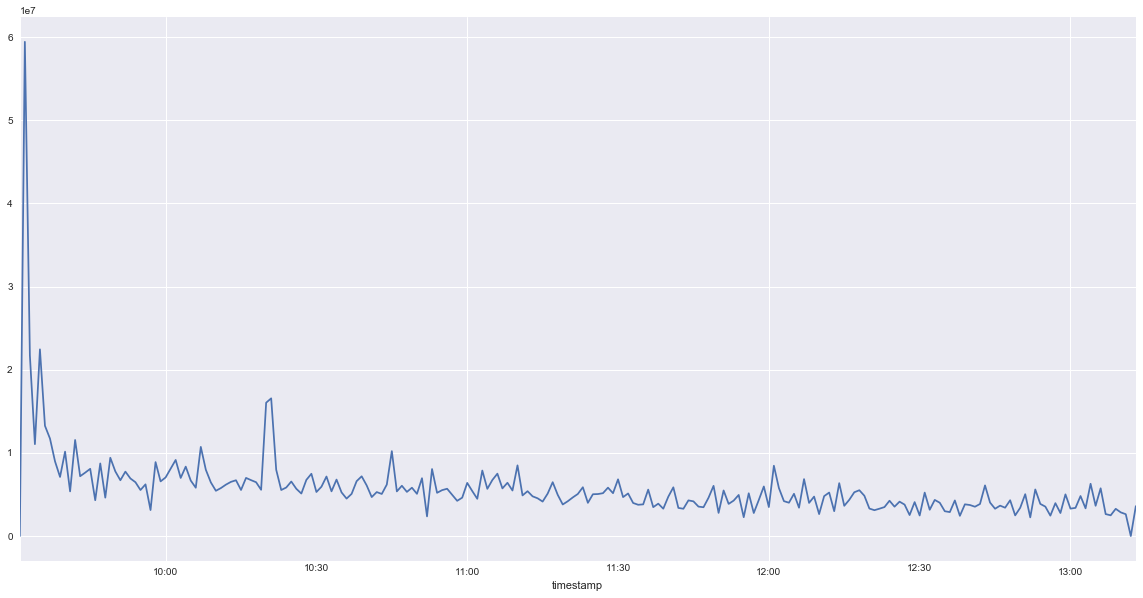

In [848]:
spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)].volume.plot(figsize = (20,10))

In [849]:
strike_pick = pd.DataFrame({'Strike': list(range(2550,2655,5))})
strike_pick['Return'] = strike_pick.Strike/2607.7 - 1
strike_pick['ImpliedReturn'] = 18.34/np.sqrt(252)/100
strike_pick

,Strike,Return,ImpliedReturn
0,2550,-0.0221,0.0116
1,2555,-0.0202,0.0116
2,2560,-0.0183,0.0116
3,2565,-0.0164,0.0116
4,2570,-0.0145,0.0116
5,2575,-0.0125,0.0116
6,2580,-0.0106,0.0116
7,2585,-0.0087,0.0116
8,2590,-0.0068,0.0116
9,2595,-0.0049,0.0116


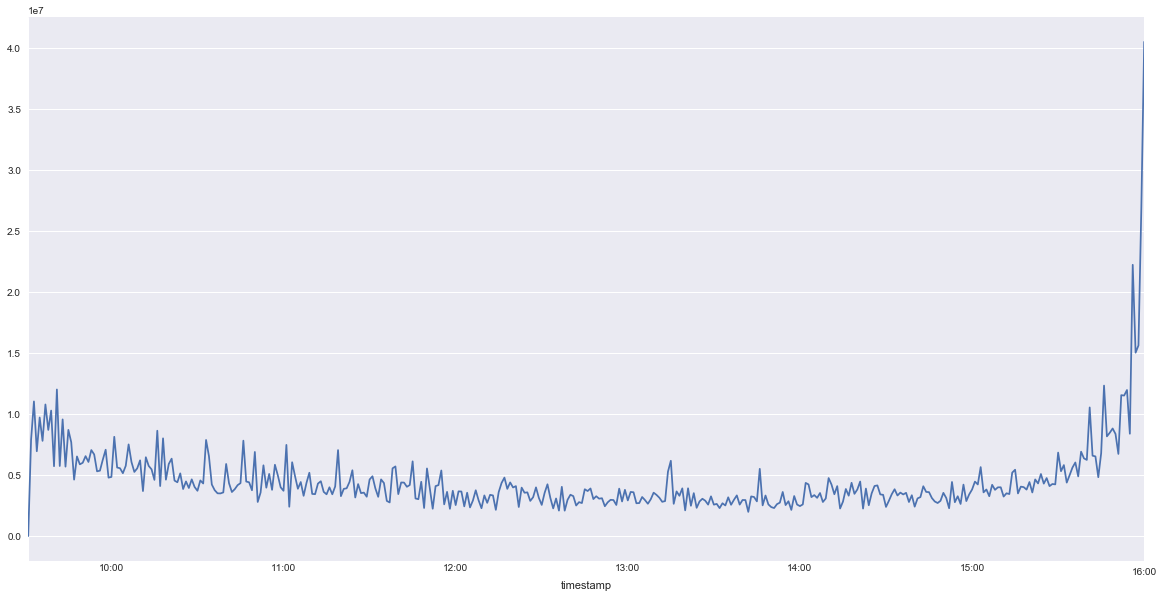

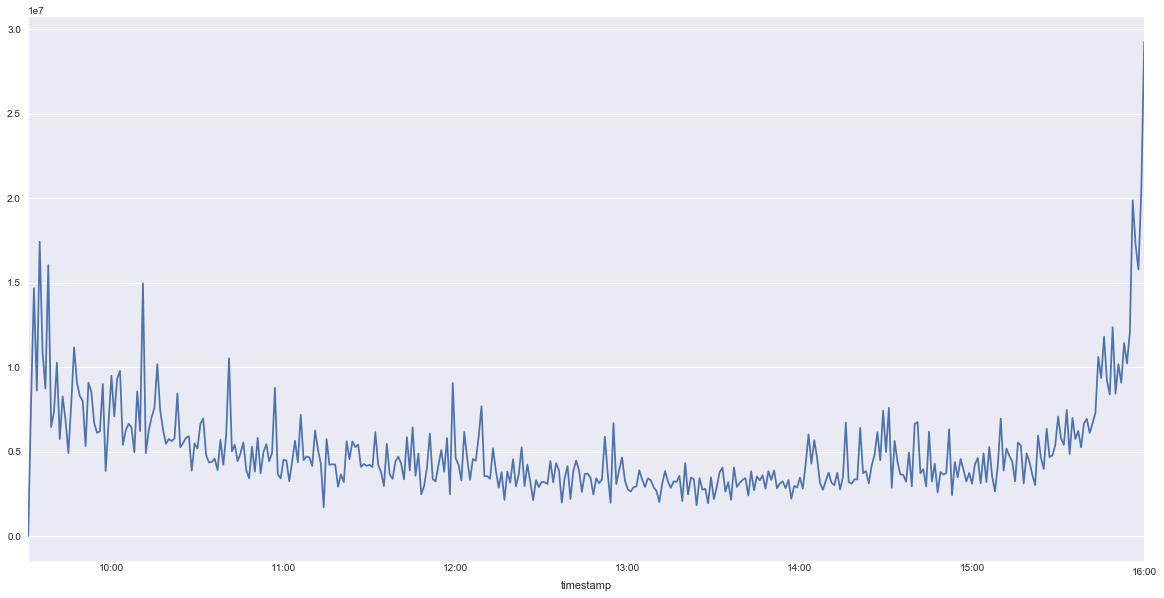

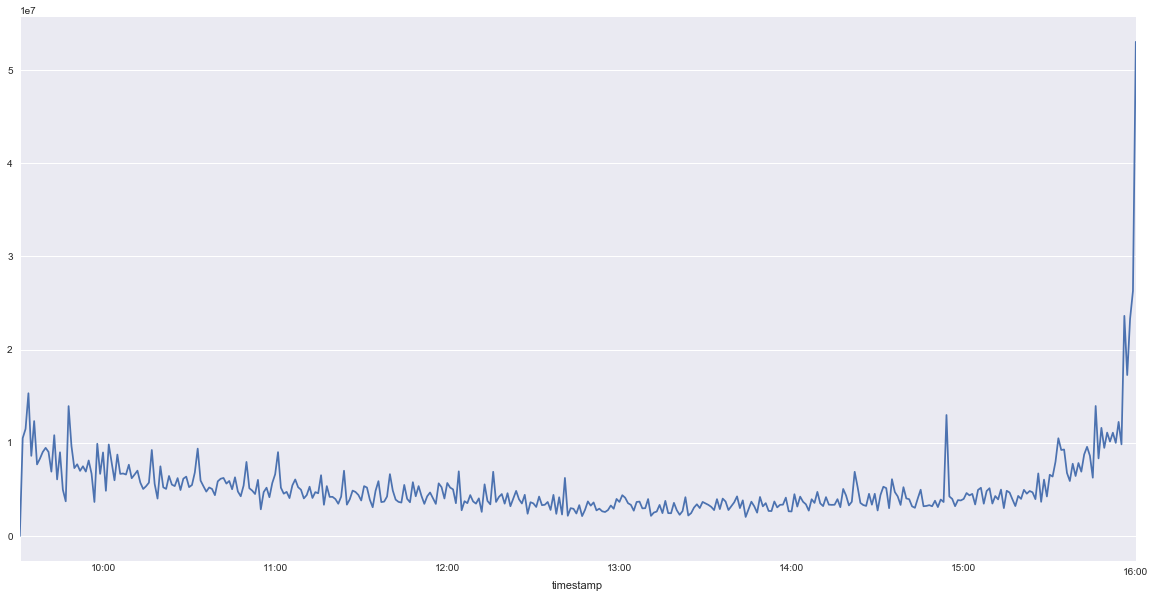

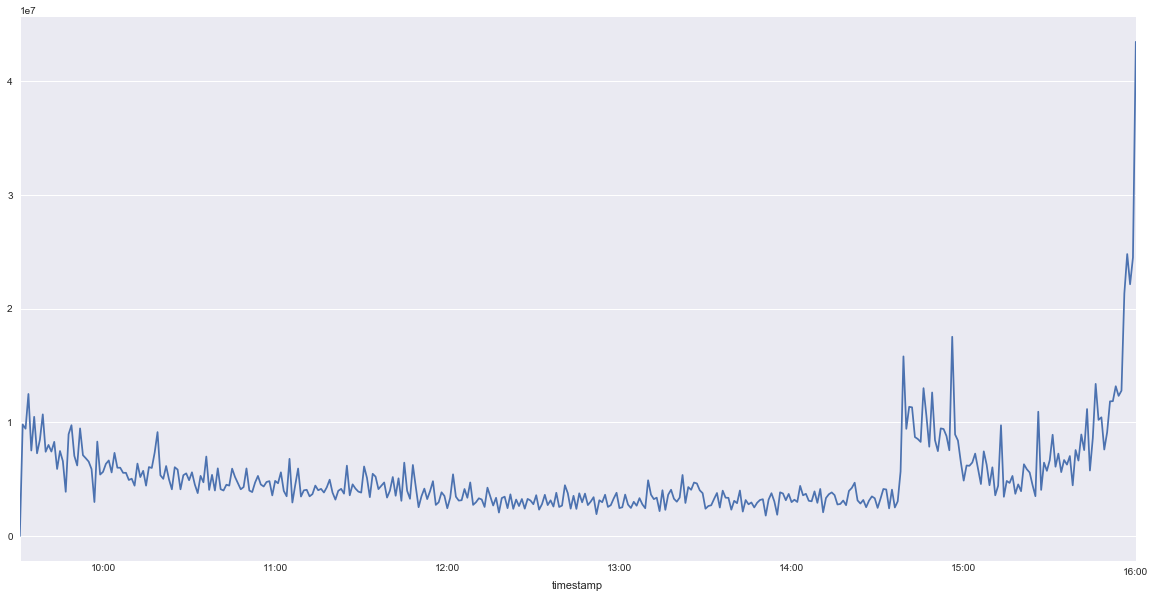

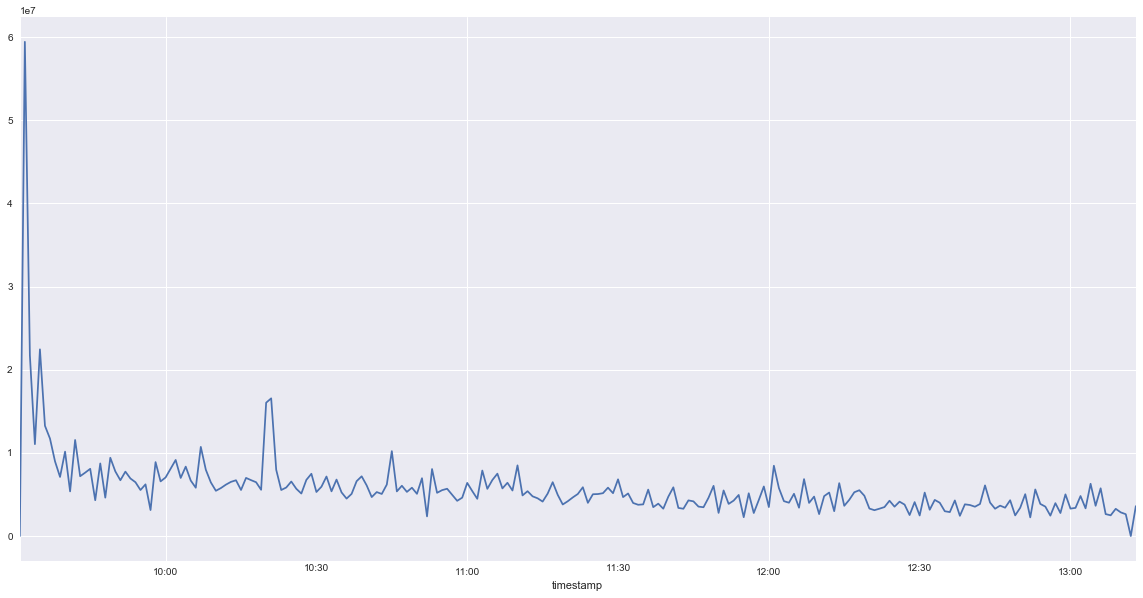

In [850]:
for date in np.unique(spx.index.date):
    spx[spx.index.date == date]['volume'].plot(figsize = (20,10))
    plt.show()

In [851]:
close_time = dt.datetime(2019,1,18,13)

curr_time = dt.datetime.now()
time_remaining = close_time - curr_time
time_remaining = time_remaining.seconds/60

iv = 0.164
strike = 2635
spot = spx.tail(1).close.values[0]
print(py_bs.black_scholes('c', spot, strike, (time_remaining/390)/365, 0.024, 0.137))
print(py_bs.black_scholes('p', spot, strike, (time_remaining/390)/(365), 0.024, 0.137))
py_greeks.delta('c', spot, strike, (time_remaining/390)/365, 0.024, 0.096)



35.7211762676
0.00735292100469


0.99995082596416085